# Analyse und Outlier-Erkennung mit realistischen Sensor-Daten

Unser Datensatz enthält Sensor-Werte die in einem Wohnungskomplex aufgenommen wurden. Zusätzlich ist ein Sensor-Wert eines Getränkeautomaten hinzugefügt, der im Eingangsbereich der Liegenschaft aufgestellt ist. 

Dieser zusätzliche Sensor misst die Vibrationen des Kühl-Kompressors des Getränkeautomaten, Spalte 'vibration'. Die übrigen Variablen sind Messwerte zur Raum-Temperatur, Luftfeuchtigkeit, Luftdruck, Strom-Verbrauch, Batterielade-Stand und Raum-Beleuchtung.

Aufgaben:

1. Analyisieren Sie das Dataset, insbesondere die Werte-Verteilungen der verschiedenen Variablen
2. Normalisieren Sie alle Werte-Variable (MinMaxScaler)
3. Wenden Sie verschiedene Methoden für die Outlier-Bestimmung an (IQR, Std-Abweichung/ZScore, IsolationForest)
4. Vergleichen Sie das Resultat der verschiedenen Outlier-Erkennungen

Referenzen:

* https://www.analyticsvidhya.com/blog/2022/10/outliers-detection-using-iqr-z-score-lof-and-dbscan/
* https://scikit-learn.org/stable/modules/outlier_detection.html
* https://scikit-learn.org/stable/modules/outlier_detection.html#overview-of-outlier-detection-methods 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(palette='Paired')

In [2]:
# Dataset einlesen
df_sensor = pd.read_csv('./datasets/sensordata.csv')
df_sensor['date'] = pd.to_datetime(df_sensor['date'], format='mixed')
df_sensor.set_index('date', inplace=True)

In [3]:
# Informationen zum Dataset
df_sensor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127489 entries, 2020-09-12 21:38:12.041000+00:00 to 2019-04-21 14:41:30.307000+00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   tenant       127489 non-null  object 
 1   temperature  37271 non-null   float64
 2   linkquality  127489 non-null  float64
 3   humidity     37270 non-null   float64
 4   pressure     37269 non-null   float64
 5   voltage      127433 non-null  float64
 6   illuminance  85646 non-null   float64
 7   battery      127433 non-null  float64
 8   vibration    127489 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 9.7+ MB


In [4]:
# Wertebereiche
df_sensor.describe()

,temperature,linkquality,humidity,pressure,voltage,illuminance,battery,vibration
count,37271.000000,127489.000000,37270.000000,37269.000000,127433.000000,85646.000000,127433.000000,127489.000000
mean,20.608816,46.785966,67.912213,1003.134285,3005.022914,88.751629,93.594987,227.972217
std,3.411249,24.792719,8.428810,22.428442,24.362925,186.854643,14.372758,121.089217
min,11.340000,2.000000,30.160000,922.000000,2825.000000,0.000000,19.000000,9.000000
25%,18.030000,28.000000,63.050000,1004.000000,2985.000000,0.000000,91.000000,136.000000
50%,20.480000,44.000000,68.400000,1010.100000,3005.000000,8.000000,100.000000,214.000000
75%,23.390000,63.000000,73.390000,1014.900000,3025.000000,70.000000,100.000000,307.000000
max,35.330000,134.000000,95.470000,1032.000000,3075.000000,1000.000000,100.000000,654.000000


In [5]:
# Daten anzeigen
df_sensor.sample(10)

,tenant,temperature,linkquality,humidity,pressure,voltage,illuminance,battery,vibration
date,,,,,,,,,
2020-08-20 11:04:42.413000+00:00,sgh0201a8c87da4.csv,NaN,21.0,NaN,NaN,3015.0,28.0,100.0,102
2020-03-02 20:43:45.079000+00:00,sgh02019d93db3f.csv,17.36,47.0,62.34,950.0,2985.0,NaN,91.0,229
2019-08-19 23:22:54.505000+00:00,sgh0201a8c87da4.csv,NaN,34.0,NaN,NaN,3005.0,9.0,100.0,166
2019-10-16 21:37:31.207000+00:00,sgh020114a6a800.csv,NaN,34.0,NaN,NaN,2995.0,16.0,97.0,166
2019-07-17 10:19:41.052000+00:00,sgh0201f6cb55ed.csv,24.07,47.0,73.12,1009.0,2985.0,NaN,91.0,229
2019-11-12 20:24:33.991000+00:00,sgh0201b9b7d045.csv,NaN,89.0,NaN,NaN,3005.0,72.0,100.0,434
2019-09-17 16:18:26.235000+00:00,sgh0201a8c87da4.csv,24.04,44.0,63.40,1006.0,3045.0,NaN,100.0,214
2019-08-08 08:54:51.952000+00:00,sgh0201e9248493.csv,23.76,23.0,72.60,1007.3,3055.0,NaN,100.0,112
2020-03-12 21:42:52.451000+00:00,sgh020177a7a91d.csv,NaN,23.0,NaN,NaN,3015.0,2.0,100.0,112


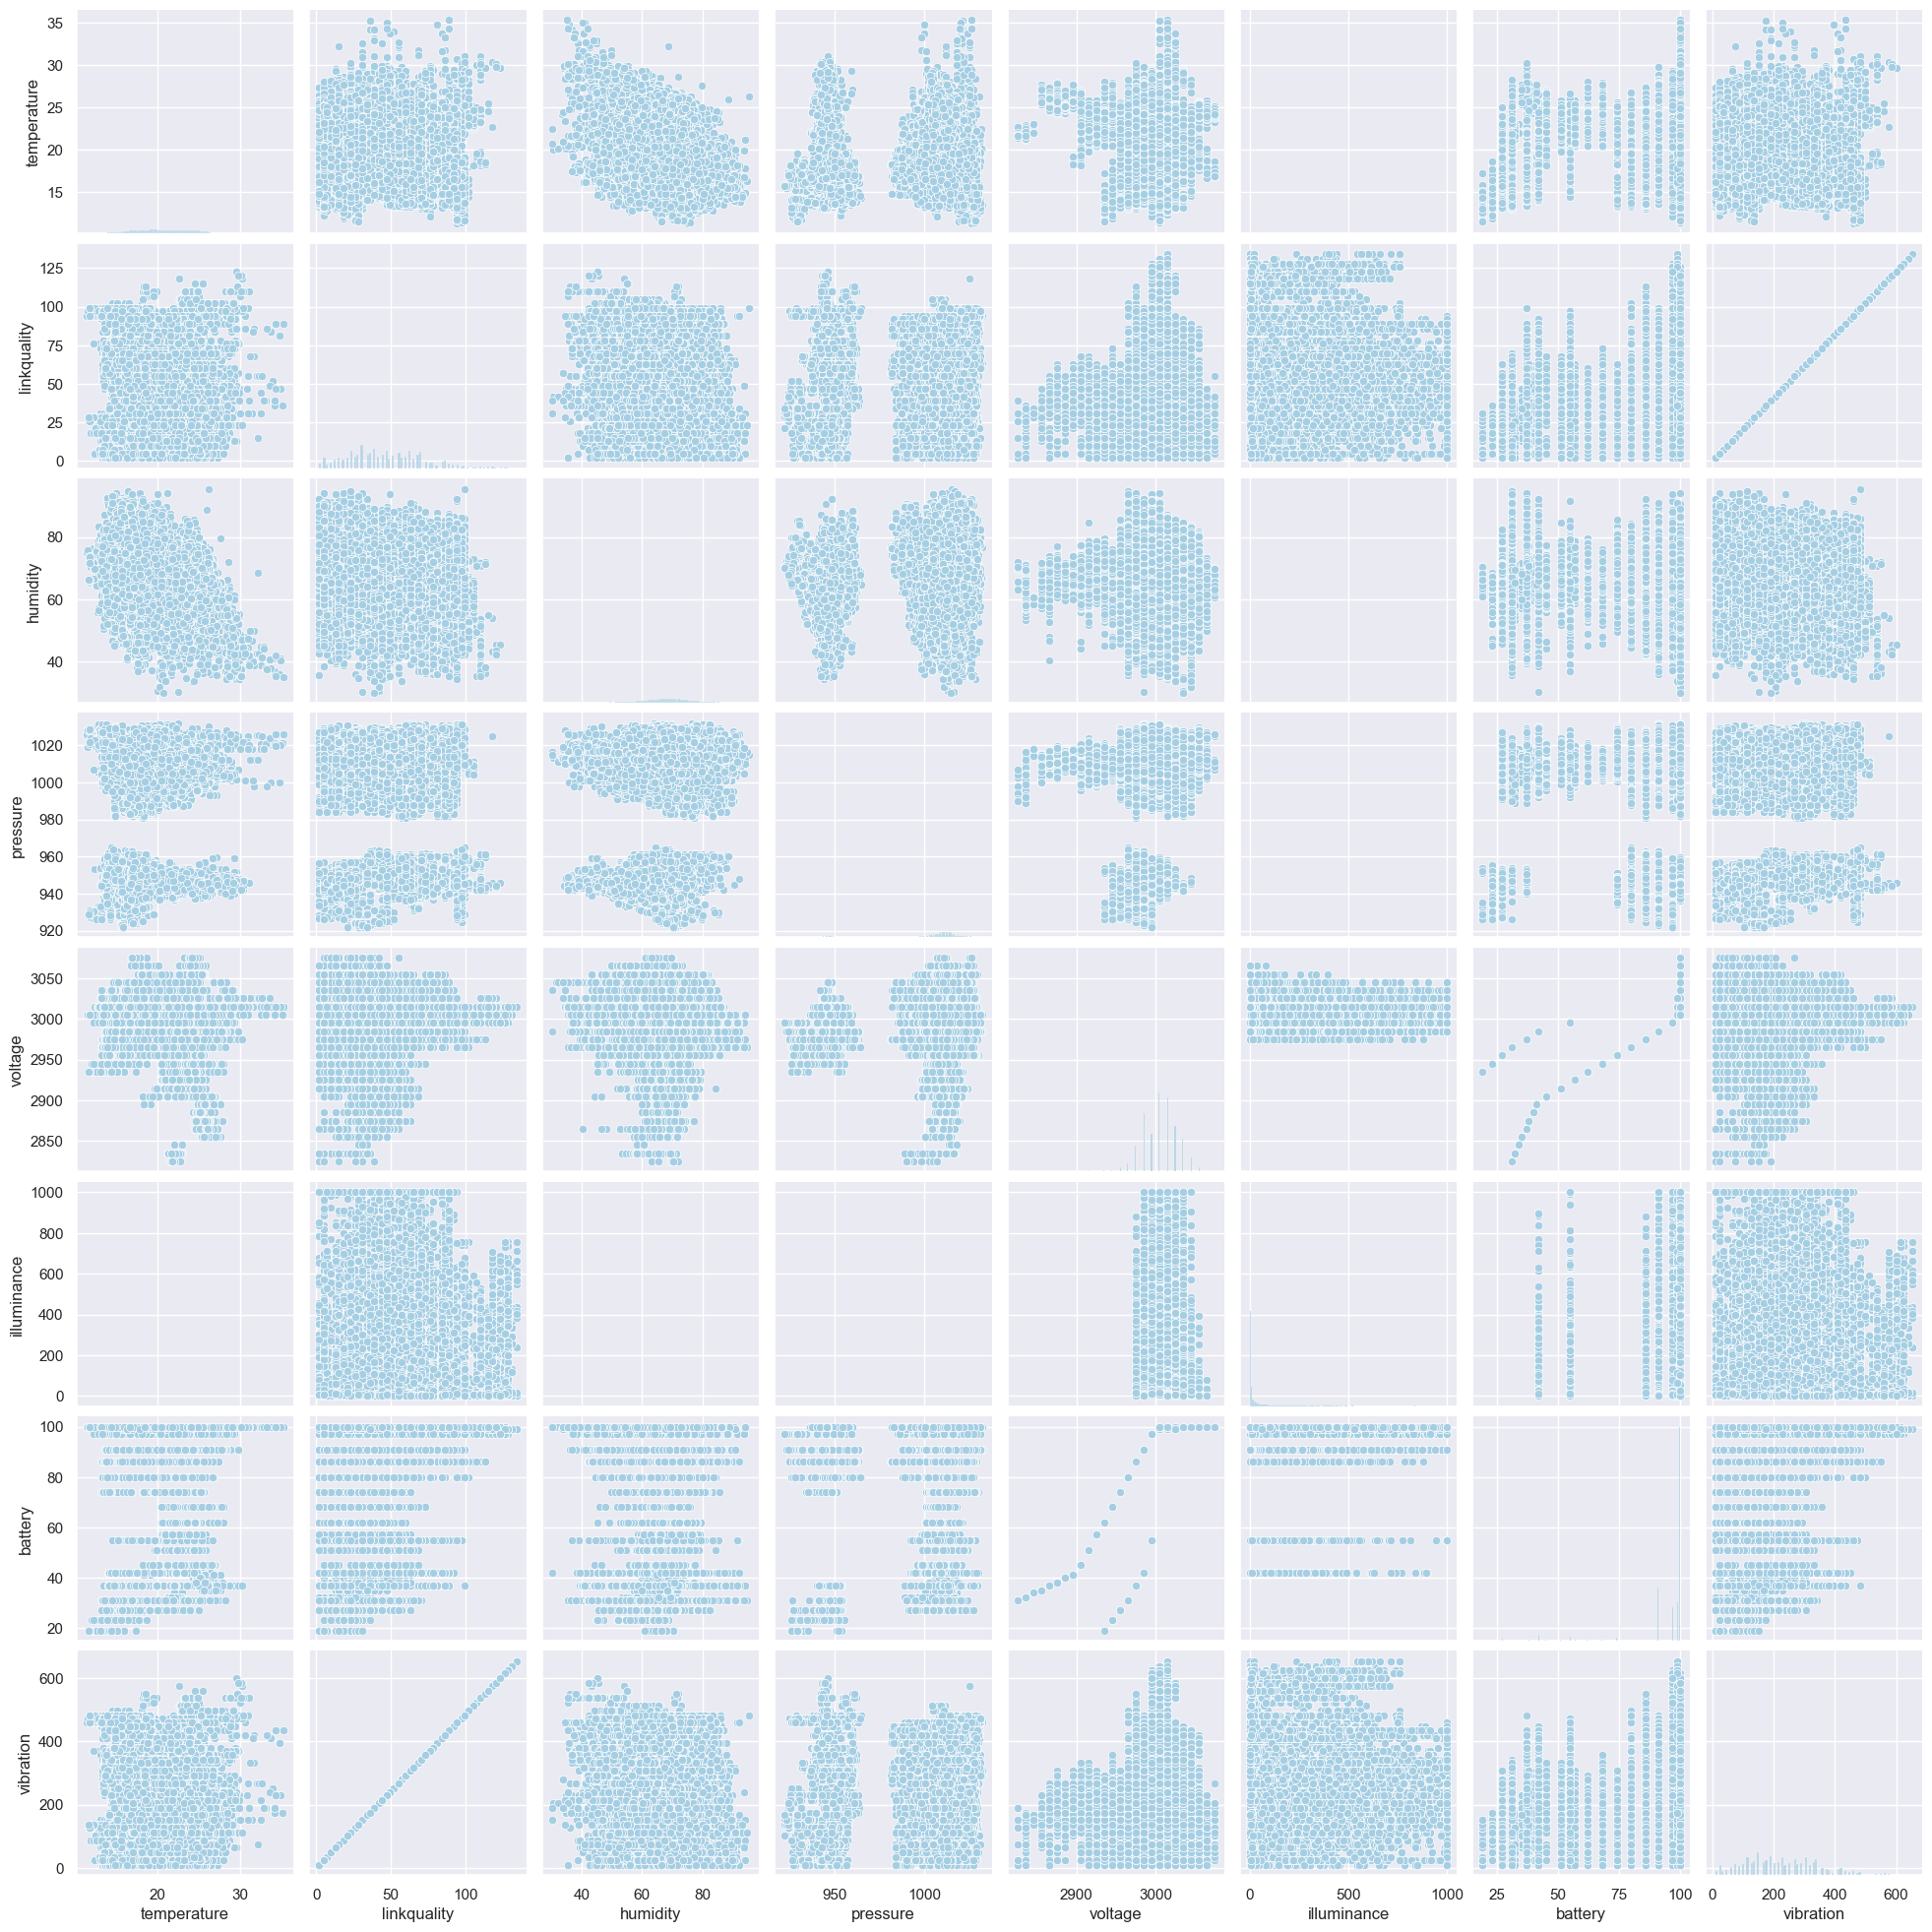

In [7]:
# Verteilungen in der Uebersicht
# -- Erstelle einen Boxplot aller Variablen
# -- Tip: Verwende z.B. plt.figure(figsize=[15,7]), um einen grösseren Plot zu erhalten
sns.pairplot(df_sensor)


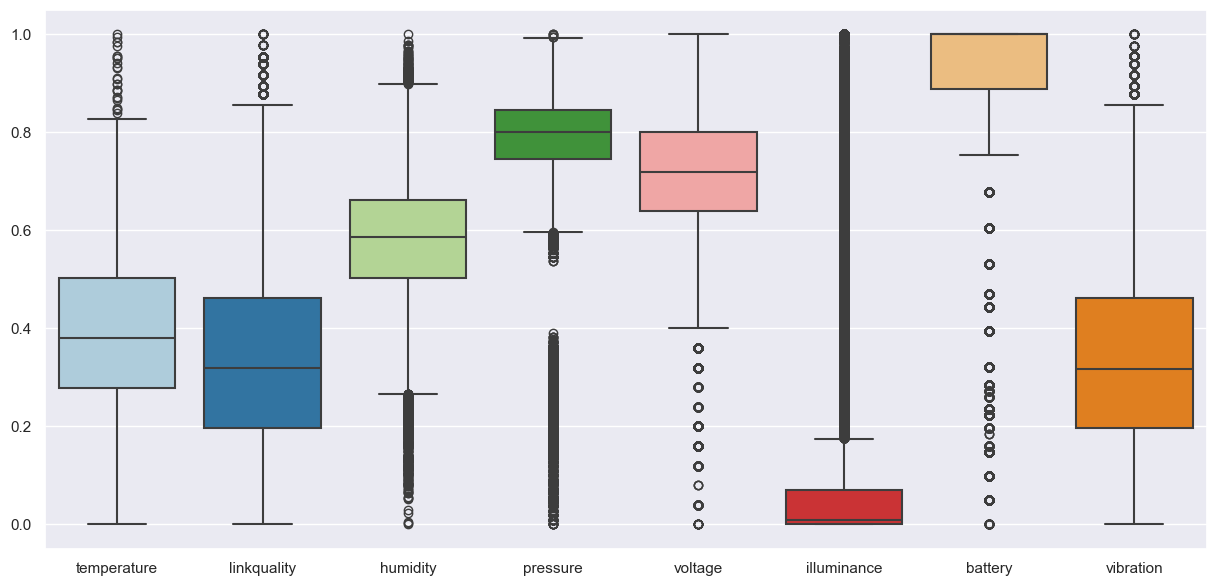

In [19]:
plt.figure(figsize=[15,7])
sns.boxplot(data=df_sensor, linewidth=1.5)
plt.show()

In [16]:
# Normalisierung
# -- Berechne die normalisierten Werte aller numerischen Variablen
# -- Tip: nutze df.select_dtypes(include=np.number).columns, um alle numerischen Variablen zu erhalten
# -- Tip: nutze MinMaxScaler.fit_transform() um die normalisierten Werte zu erhalten
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_cols = df_sensor.select_dtypes(include=np.number).columns
df_sensor[num_cols] = scaler.fit_transform(df_sensor[num_cols])

print(df_sensor.describe())

        temperature    linkquality      humidity      pressure        voltage  \
count  37271.000000  127489.000000  37270.000000  37269.000000  127433.000000   
mean       0.386362       0.339288      0.578046      0.737584       0.720092   
std        0.142195       0.187824      0.129058      0.203895       0.097452   
min        0.000000       0.000000      0.000000      0.000000       0.000000   
25%        0.278866       0.196970      0.503598      0.745455       0.640000   
50%        0.380992       0.318182      0.585515      0.800909       0.720000   
75%        0.502293       0.462121      0.661920      0.844545       0.800000   
max        1.000000       1.000000      1.000000      1.000000       1.000000   

        illuminance        battery      vibration  
count  85646.000000  127433.000000  127489.000000  
mean       0.088752       0.920926       0.339492  
std        0.186855       0.177441       0.187735  
min        0.000000       0.000000       0.000000  
25%       

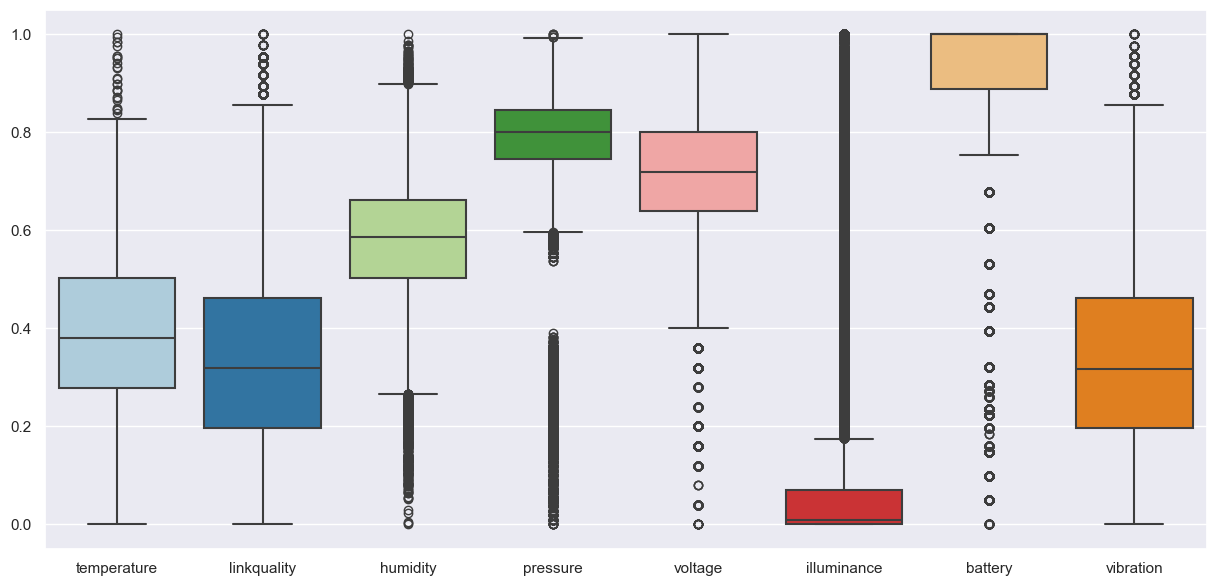

In [17]:
# Verteilungen in der Uebersicht mit normalisierten Variablen
# -- Erstelle einen Boxplot aller Variablen
# -- Tip: Verwende z.B. plt.figure(figsize=[15,7]), um einen grösseren Plot zu erhalten
plt.figure(figsize=[15,7])
sns.boxplot(data=df_sensor, linewidth=1.5)
plt.show()

In [26]:
# Outlier nach Std / ZScore
# -- berechne die Spalte 'outlier' sodass Outlier jene Werte sind, die plus/minus einen Zscore von abs(3) aufweisen
# -- die Spalte 'outlier' soll -1 für Outlier, Normalwerte mit +1 bezeichnen
from scipy.stats import zscore

# only check 'vibration' column
df_sensor['outlier'] = np.where(np.abs(zscore(df_sensor['vibration'])) > 3, -1, 1)

<Axes: xlabel='date', ylabel='vibration'>

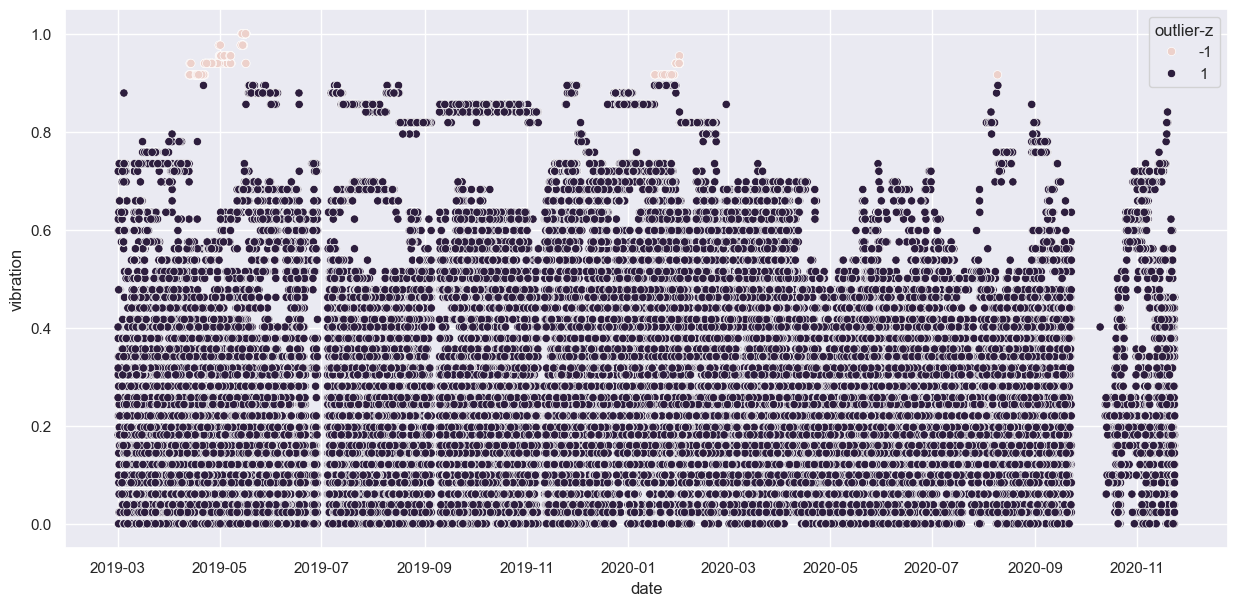

In [22]:
# Plotte die Outlier v.v. Normalwerte 
# -- Tipp: Verwende sns.scatterplot() mit x=df.index, y='virbration' und hue='outlier'
plt.figure(figsize=[15,7])
sns.scatterplot(data=df_sensor, x=df_sensor.index, y='vibration', hue='outlier')

In [ ]:
# Berechne Outlier nach IQR
# -- berechne die Spalte 'outlier' sodass Outlier jene Werte sind, die +-1.5 IQR des unteren (.25) bzw. oberen Quartil (.75) liegen
# -- die Spalte 'outlier' soll -1 für Outlier, Normalwerte mit +1 bezeichnen
q1 = df_sensor['vibration'].quantile(.25)
q3 = df_sensor['vibration'].quantile(.75)
iqr = q3 - q1
cutoff = 1.5 * iqr # üblicherweise 1.5 
df_sensor['outlier'] = <DEIN CODE>

In [ ]:
# Plotte die Outlier v.v. Normalwerte 
# -- Tipp: Verwende sns.scatterplot() mit x=df.index, y='virbration' und hue='outlier'
<DEIN CODE>

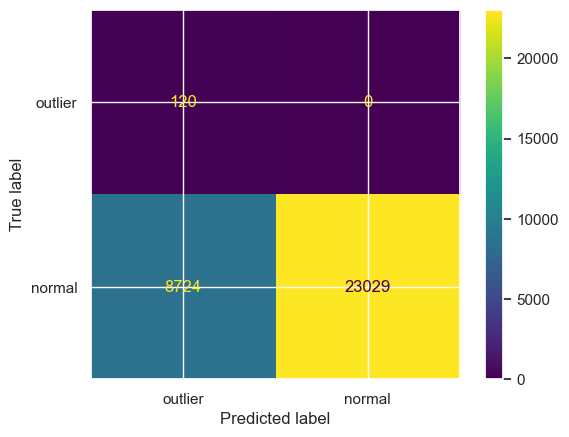

In [25]:
# Outlier nach IsolationForest 
# -- berechne die Spalte 'outlier' sodass Outlier jene Werte sind, die von einem IsolationForest Model als solche erkannt werden
# -- die Spalte 'outlier' soll -1 für Outlier, Normalwerte mit +1 bezeichnen
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

columns = df_sensor.select_dtypes(np.number).columns
columns = ['outlier-z', 'vibration']
# prepare data
dfx = (df_sensor[columns]
       .fillna(0))

df_train, df_test = train_test_split(dfx)
y_true = df_test['outlier-z']

# ensure we don't train our true value outlier
columns = list(set(columns) - set(['outlier']))

# train model and predict
model = IsolationForest()
model.fit(df_train[columns])

y_test = model.predict(df_test[columns])

# validate -- n.B. this validates against IQR based outlier detection: cannot expect high accuracy
cm = confusion_matrix(y_true, y_test)
cmplot = ConfusionMatrixDisplay(cm, display_labels=['outlier', 'normal'])
cmplot.plot()

In [ ]:
# Plot Outliers IQR vs. ISF 
# -- vergleiche Outlier nach IQR bzw. nach ISF
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
# plot known outliers
sns.scatterplot(df_test, 
                x=df_test.index, 
                y='vibration', 
                hue='outlier', 
                ax=axs[0])
# plot predicted outliers
sns.scatterplot(df_test, 
                x=df_test.index, 
                y='vibration', 
                hue='predicted', 
                palette='tab10', 
                ax=axs[1])
for ax in axs:
    ax.tick_params(labelrotation=90)
plt.show()